In [14]:
import json
import requests
import pandas as pd

In [15]:
response = requests.get("http://127.0.0.1:9090/EPA/air-quality-resp")
# response = main()

In [16]:
data = response.json().get('data')

Visualize the air quality index

/home/kaishengsu/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


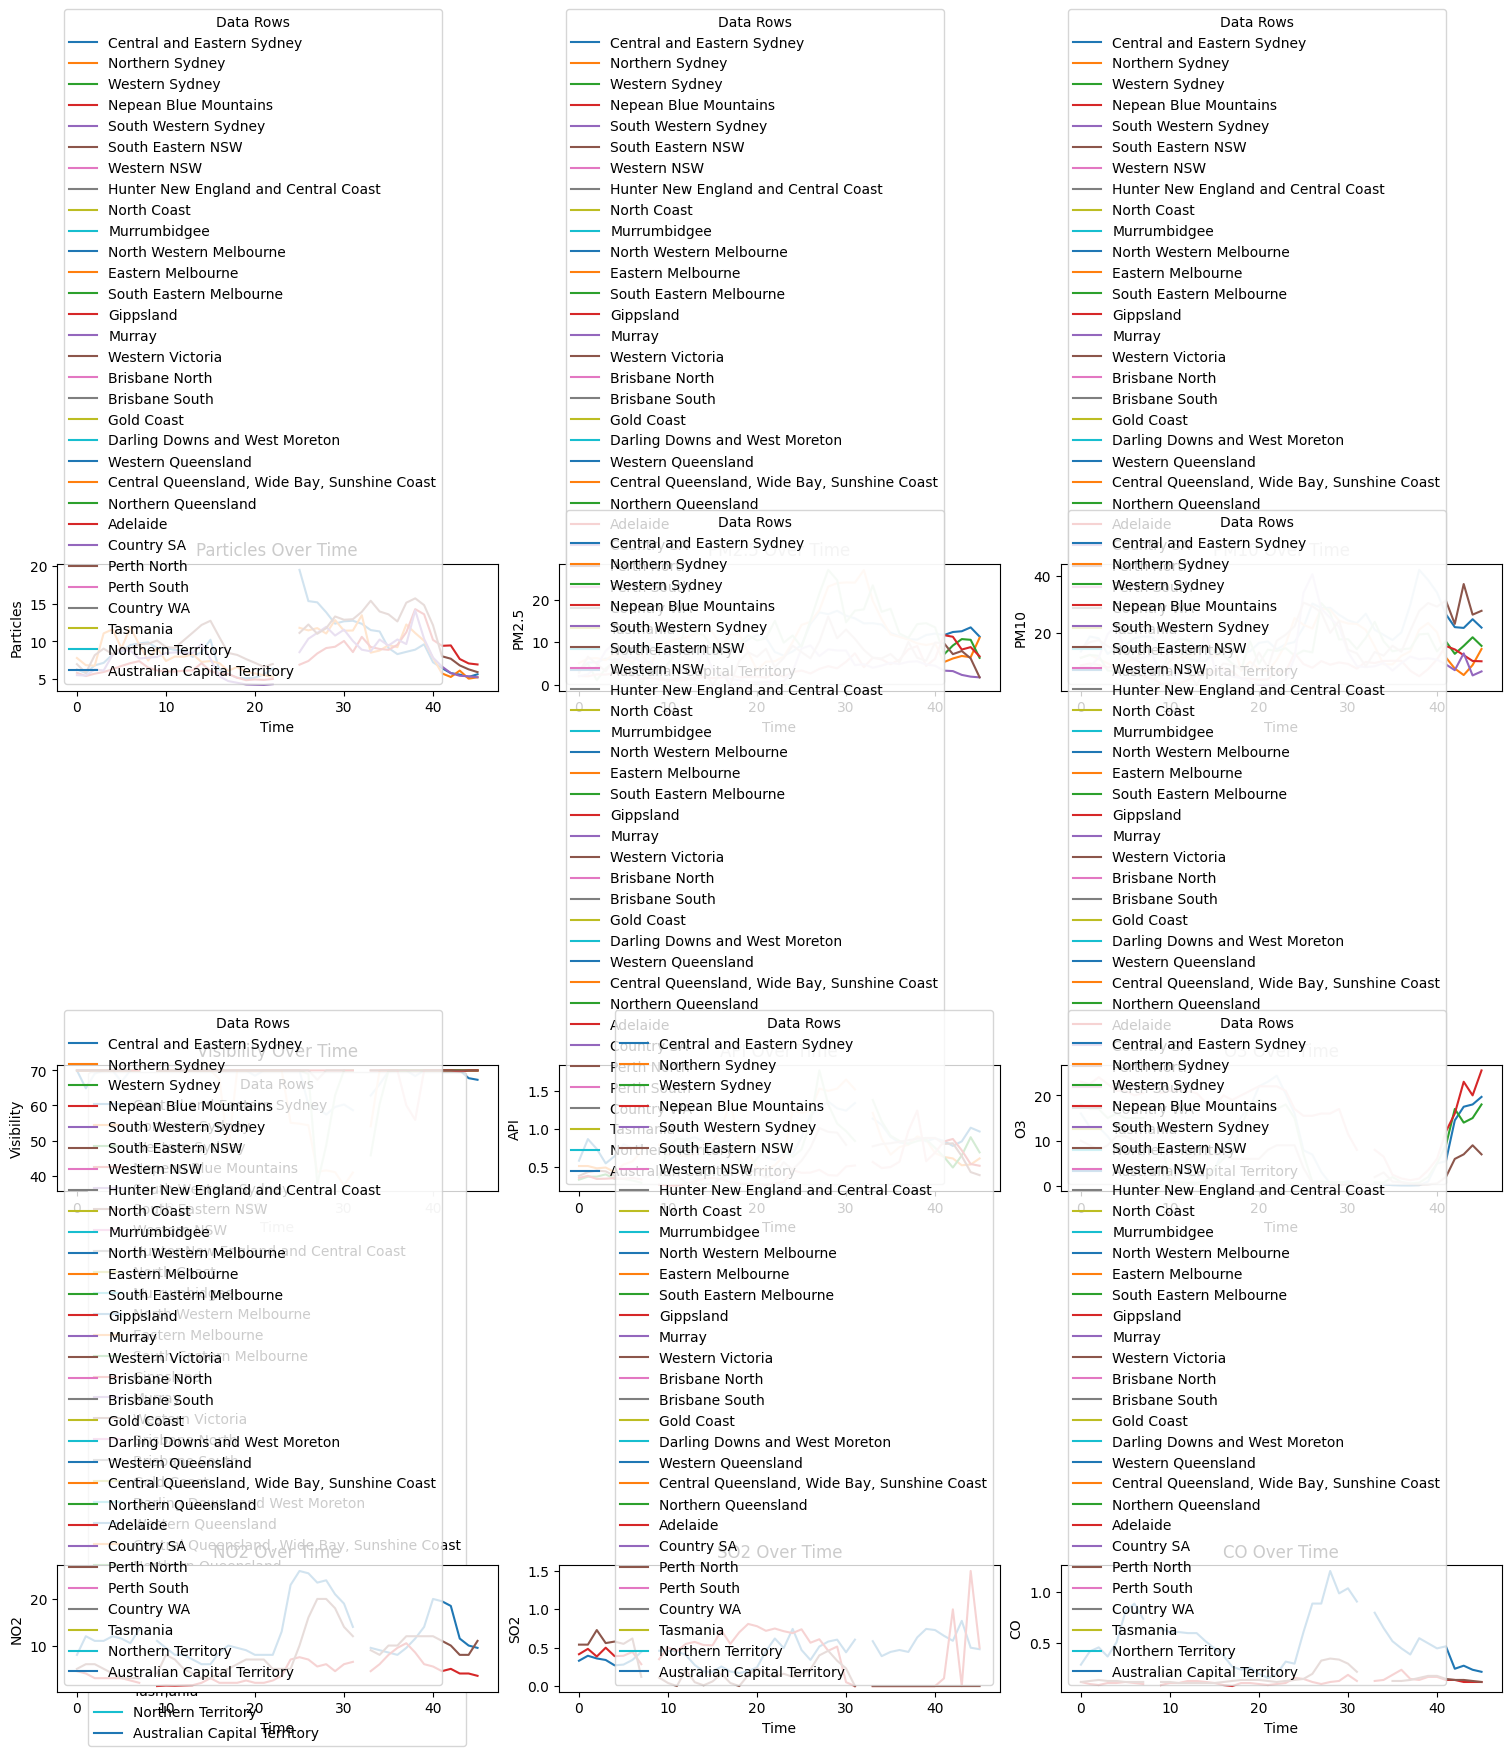

In [23]:
import matplotlib.pyplot as plt
df = pd.json_normalize(data)  # 使用 json_normalize() 函数加载数据到 DataFrame


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']
fig, axes = plt.subplots(3, 3, figsize=(15, 3 * 5), constrained_layout=True)
df.dropna(how='all', subset=df.columns[4:], inplace=True)
# 对于每个特征，将列表展开成新的列
for idx, feature in enumerate(features):
    ax = axes[idx // 3, idx % 3]
    for row_idx, row in df.iterrows():
        if isinstance(row[feature], list):  
            ax.plot(range(len(row[feature])), row[feature], label=row['phn_name'])
    ax.set_title(f'{feature} Over Time')
    ax.set_xlabel('Time')
    ax.set_ylabel(feature)
    ax.legend(title='Data Rows')

plt.show()

Average values of polutions in Public Health Network (PHN) areas in Victoria 

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data)  # 使用 json_normalize() 函数加载数据到 DataFrame


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']


for feature in features:
    # df = pd.concat([df, df[feature].apply(pd.Series).add_prefix(feature+'_')], axis=1)
    df[feature+'_mean'] = df[feature].apply(lambda x: sum(filter(None, x))/len(x) if isinstance(x, list) and any(x) else None)

# 删除原始的特征列
df.drop(columns=features, inplace=True)
df.dropna(how='all', subset=df.columns[4:], inplace=True)
df.drop(columns=['_id'])

df

,_id,death_ratio,phn_code,phn_name,Particles_mean,PM2.5_mean,PM10_mean,Visibility_mean,API_mean,O3_mean,NO2_mean,SO2_mean,CO_mean
10,jszfhI8BrPb-hKkECSrc,0.000134,PHN201,North Western Melbourne,8.508250,10.296638,20.256413,64.932862,0.821630,7.940000,12.043478,0.426739,0.503478
11,j8zfhI8BrPb-hKkECSrc,0.000092,PHN202,Eastern Melbourne,8.253768,11.012500,14.584565,61.843696,0.788913,NaN,NaN,NaN,NaN
12,kMzfhI8BrPb-hKkEDirw,0.000120,PHN203,South Eastern Melbourne,NaN,10.972283,14.195217,64.876739,0.708913,8.186522,NaN,NaN,NaN
13,kczfhI8BrPb-hKkEHSpn,0.000147,PHN204,Gippsland,7.247003,3.952500,7.898087,66.426957,0.429638,15.774783,4.022065,0.419130,0.120000
14,kszfhI8BrPb-hKkEJyr-,0.000178,PHN205,Murray,7.560605,4.347283,11.367935,NaN,NaN,NaN,NaN,NaN,NaN
15,k8zfhI8BrPb-hKkENSoX,0.000178,PHN206,Western Victoria,9.863231,5.971739,16.650000,63.855000,0.518478,4.860435,7.891304,0.166304,0.143696


Correlation matrix to analyse the relativity of different pollutant with the respiratory system mortality

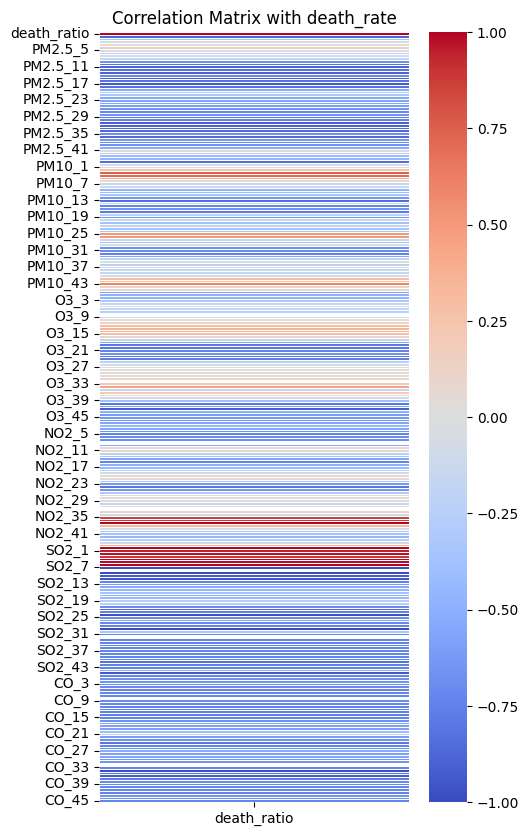

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.json_normalize(data)  # 使用 json_normalize() 函数加载数据到 DataFrame


features = ['Particles', 'PM2.5', 'PM10', 'Visibility', 'API', 'O3', 'NO2', 'SO2', 'CO']
# 假设 df 是你的 DataFrame，features 是要展开的特征列表
pollutant_features = ['PM2.5', 'PM10', 'O3', 'NO2', 'SO2', 'CO']

# 对于每个特征，将列表展开成新的列
for feature in pollutant_features:
    # 对于每个特征，将列表展开成新的列，并命名为原特征名加上索引
    df = pd.concat([df, df[feature].apply(pd.Series).add_prefix(feature+'_')], axis=1)
    # df[feature+'_mean'] = df[feature].apply(lambda x: sum(filter(None, x))/len(x) if isinstance(x, list) and any(x) else None)

# 删除原始的特征列
df.drop(columns=features, inplace=True)

df = df.dropna(subset=df.columns[4:], how='all')

df = df.drop(columns=['_id','phn_code', 'phn_name'])
correlation_matrix = df.corr()
# 绘制热图
plt.figure(figsize=(5, 10))
sns.heatmap(correlation_matrix[['death_ratio']], annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix with death_rate")
plt.show()

